# Hyperparameter Tuning on CIFAR-100

**Purpose:**  
This notebook demonstrates **hyperparameter tuning** step by step using a **simple CNN** for learning purposes:

1. Start with a **baseline model** with default hyperparameters (random-like performance).  
2. Try **manual hyperparameter tuning** (learning rate, batch size) to see the effect on learning.  
3. Explore **Grid Search** (systematic search) and **Random Search** to find better configurations.  
4. Retrain the model with **best hyperparameters** found from previous steps.  

> ⚠️ Note: We are using a **small CNN and limited epochs** to keep things simple and educational.  
> For real-world applications, deeper models, data augmentation, and transfer learning are recommended for higher accuracy.  

**Learning Goal:**  
Understand **how hyperparameters affect model training and validation performance**, not to achieve maximum accuracy on CIFAR-100.


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import itertools

# Fix seeds for reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)


In [2]:
# Load full CIFAR-100 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data(label_mode='fine')

# Normalize
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Print dataset shapes
print('Train:', x_train.shape, 'Test:', x_test.shape)
print('Number of classes:', len(np.unique(y_train)))


Train: (50000, 32, 32, 3) Test: (10000, 32, 32, 3)
Number of classes: 100


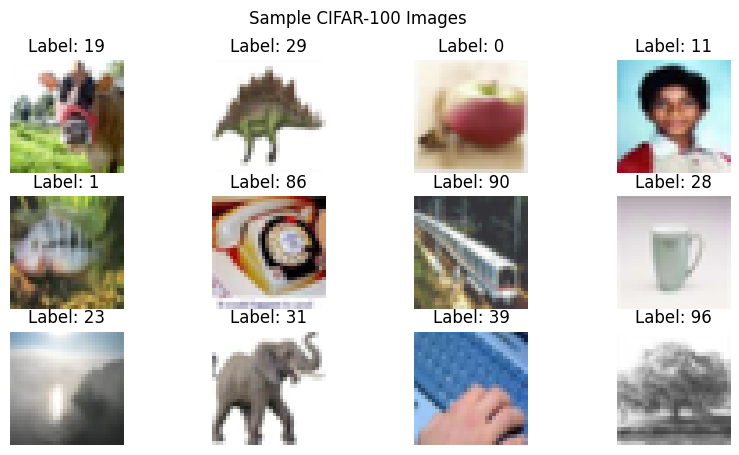

In [3]:
# Visualize some CIFAR-100 images
plt.figure(figsize=(10,5))
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow(x_train[i])
    plt.title(f'Label: {y_train[i][0]}')
    plt.axis('off')
plt.suptitle('Sample CIFAR-100 Images')
plt.show()

In [4]:
# Build Simple CNN Model
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same', input_shape=(32,32,3)),
        tf.keras.layers.MaxPool2D(2),
        tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(100, activation='softmax')
    ])
    return model

# Show model summary
model = build_model()
model.summary()


D:\miniconda_setup\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100)                 │          12,900 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 556,708 (2.12 MB)

 Trainable params: 556,708 (2.12 MB)

 Non-trainable params: 0 (0.00 B)

### Baseline Model
We train the model with **default hyperparameters** to see initial performance.


Epoch 1/3
704/704 - 35s - 50ms/step - accuracy: 0.0874 - loss: 4.0181 - val_accuracy: 0.1808 - val_loss: 3.4779
Epoch 2/3
704/704 - 34s - 48ms/step - accuracy: 0.1798 - loss: 3.4151 - val_accuracy: 0.2414 - val_loss: 3.1355
Epoch 3/3
704/704 - 30s - 42ms/step - accuracy: 0.2251 - loss: 3.1538 - val_accuracy: 0.2730 - val_loss: 2.9931
Baseline validation accuracy: 0.27300000190734863


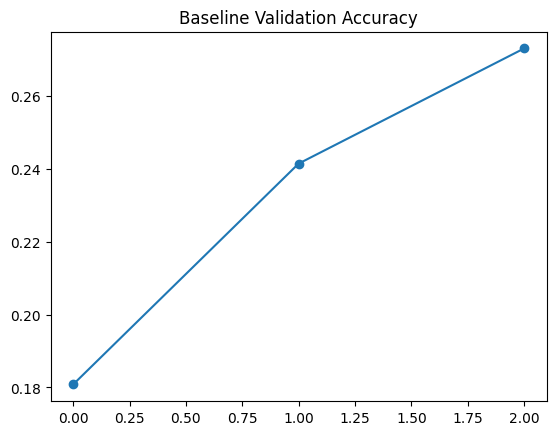

In [5]:
model = build_model()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    validation_split=0.1,
                    epochs=3,   # short for baseline
                    batch_size=64,
                    verbose=2)

# Show baseline accuracy
print('Baseline validation accuracy:', history.history['val_accuracy'][-1])

# Plot
plt.plot(history.history['val_accuracy'], 'o-')
plt.title('Baseline Validation Accuracy')
plt.show()


### Manual Hyperparameter Tuning
Now we manually try different **learning rates** and **batch sizes** to see how they affect performance.


In [7]:
learning_rates = [1e-2, 1e-3, 1e-4]
batch_sizes = [32, 64]

manual_results = []

for lr in learning_rates:
    for bs in batch_sizes:
        print(f'Training with lr={lr}, batch_size={bs}')
        model = build_model()
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
        history = model.fit(x_train, y_train,
                            validation_split=0.1,
                            epochs=3,
                            batch_size=bs,
                            verbose=0)
        val_acc = history.history['val_accuracy'][-1]
        print(f'Validation accuracy = {val_acc:.4f}')
        manual_results.append({'learning_rate': lr, 'batch_size': bs, 'val_accuracy': val_acc})

pd.DataFrame(manual_results)


Training with lr=0.01, batch_size=32
Validation accuracy = 0.0084
Training with lr=0.01, batch_size=64
Validation accuracy = 0.0084
Training with lr=0.001, batch_size=32
Validation accuracy = 0.3012
Training with lr=0.001, batch_size=64
Validation accuracy = 0.2778
Training with lr=0.0001, batch_size=32
Validation accuracy = 0.1676
Training with lr=0.0001, batch_size=64
Validation accuracy = 0.1618


,learning_rate,batch_size,val_accuracy
0,0.0100,32,0.0084
1,0.0100,64,0.0084
2,0.0010,32,0.3012
3,0.0010,64,0.2778
4,0.0001,32,0.1676
5,0.0001,64,0.1618


### Grid Search
We systematically try all combinations of selected learning rates and batch sizes to find the best configuration.


In [8]:
grid_results = []

for lr in [1e-3, 1e-4]:
    for bs in [32, 64, 128]:
        print(f'Training with lr={lr}, batch_size={bs}')
        model = build_model()
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
        history = model.fit(x_train, y_train,
                            validation_split=0.1,
                            epochs=3,
                            batch_size=bs,
                            verbose=0)
        val_acc = history.history['val_accuracy'][-1]
        print(f'Validation accuracy = {val_acc:.4f}')
        grid_results.append({'learning_rate': lr, 'batch_size': bs, 'val_accuracy': val_acc})

grid_df = pd.DataFrame(grid_results)
grid_df


Training with lr=0.001, batch_size=32


D:\miniconda_setup\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation accuracy = 0.2714
Training with lr=0.001, batch_size=64
Validation accuracy = 0.2858
Training with lr=0.001, batch_size=128
Validation accuracy = 0.2516
Training with lr=0.0001, batch_size=32
Validation accuracy = 0.1788
Training with lr=0.0001, batch_size=64
Validation accuracy = 0.1662
Training with lr=0.0001, batch_size=128
Validation accuracy = 0.1398


,learning_rate,batch_size,val_accuracy
0,0.0010,32,0.2714
1,0.0010,64,0.2858
2,0.0010,128,0.2516
3,0.0001,32,0.1788
4,0.0001,64,0.1662
5,0.0001,128,0.1398


### Random Search
Randomly pick a few hyperparameter combinations to find a good configuration faster.


In [9]:
all_combinations = list(itertools.product([1e-2, 1e-3, 1e-4], [32, 64, 128]))
random.shuffle(all_combinations)
random_samples = all_combinations[:4]

random_results = []

for lr, bs in random_samples:
    print(f'Training with lr={lr}, batch_size={bs}')
    model = build_model()
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(x_train, y_train,
                        validation_split=0.1,
                        epochs=3,
                        batch_size=bs,
                        verbose=0)
    val_acc = history.history['val_accuracy'][-1]
    print(f'Validation accuracy = {val_acc:.4f}')
    random_results.append({'learning_rate': lr, 'batch_size': bs, 'val_accuracy': val_acc})

random_df = pd.DataFrame(random_results)
random_df
 

Training with lr=0.01, batch_size=128


D:\miniconda_setup\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation accuracy = 0.1410
Training with lr=0.001, batch_size=64
Validation accuracy = 0.2820
Training with lr=0.0001, batch_size=64
Validation accuracy = 0.1536
Training with lr=0.01, batch_size=64
Validation accuracy = 0.0084


,learning_rate,batch_size,val_accuracy
0,0.0100,128,0.1410
1,0.0010,64,0.2820
2,0.0001,64,0.1536
3,0.0100,64,0.0084


### Retrain Model with Best Hyperparameters
We now train the model with the **best configuration** from previous search.


Epoch 1/5
704/704 - 36s - 51ms/step - accuracy: 0.0803 - loss: 4.0571 - val_accuracy: 0.1710 - val_loss: 3.5231
Epoch 2/5
704/704 - 28s - 40ms/step - accuracy: 0.1742 - loss: 3.4617 - val_accuracy: 0.2308 - val_loss: 3.1993
Epoch 3/5
704/704 - 33s - 47ms/step - accuracy: 0.2148 - loss: 3.2070 - val_accuracy: 0.2672 - val_loss: 2.9987
Epoch 4/5
704/704 - 26s - 37ms/step - accuracy: 0.2465 - loss: 3.0480 - val_accuracy: 0.2748 - val_loss: 2.9045
Epoch 5/5
704/704 - 26s - 37ms/step - accuracy: 0.2657 - loss: 2.9278 - val_accuracy: 0.2938 - val_loss: 2.8188


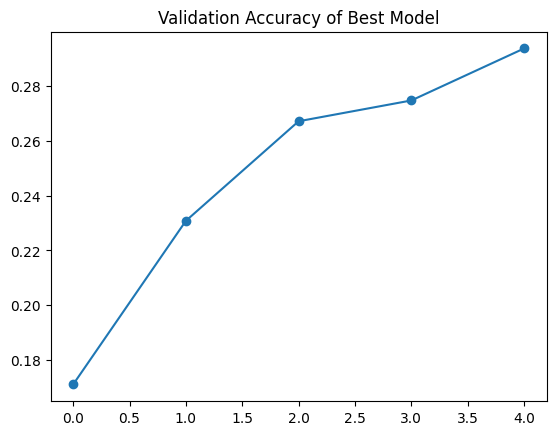

In [12]:
# Example: best from grid or random search
best_lr = 1e-3
best_batch = 64

model = build_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_lr),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    validation_split=0.1,
                    epochs=5,
                    batch_size=int(best_batch),
                    verbose=2)

plt.plot(history.history['val_accuracy'], 'o-')
plt.title('Validation Accuracy of Best Model')
plt.show()


### Retrain Best Model
We pick the **best hyperparameters** from previous search and retrain for more epochs.


Best Learning Rate: 0.001, Best Batch Size: 64.0


D:\miniconda_setup\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
704/704 - 35s - 50ms/step - accuracy: 0.0767 - loss: 4.0737 - val_accuracy: 0.1738 - val_loss: 3.5427
Epoch 2/5
704/704 - 29s - 41ms/step - accuracy: 0.1642 - loss: 3.4970 - val_accuracy: 0.2318 - val_loss: 3.2154
Epoch 3/5
704/704 - 27s - 38ms/step - accuracy: 0.2084 - loss: 3.2539 - val_accuracy: 0.2658 - val_loss: 3.0512
Epoch 4/5
704/704 - 29s - 41ms/step - accuracy: 0.2334 - loss: 3.0841 - val_accuracy: 0.2814 - val_loss: 2.9309
Epoch 5/5
704/704 - 28s - 40ms/step - accuracy: 0.2615 - loss: 2.9614 - val_accuracy: 0.2980 - val_loss: 2.8303


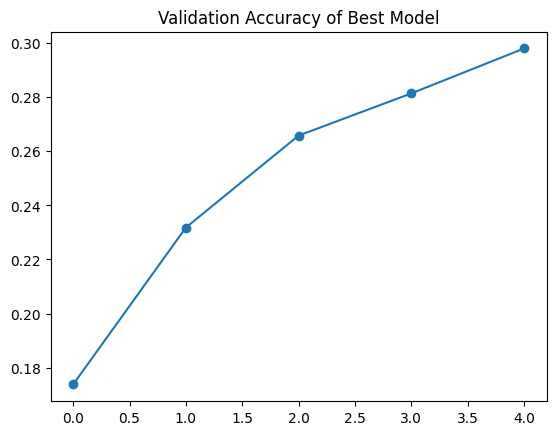

In [13]:
best_config = grid_df.loc[grid_df['val_accuracy'].idxmax()]
best_lr = best_config['learning_rate']
best_batch = best_config['batch_size']

print(f"Best Learning Rate: {best_lr}, Best Batch Size: {best_batch}")

model = build_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_lr),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    validation_split=0.1,
                    epochs=5,   # train longer with best config
                    batch_size=int(best_batch),
                    verbose=2)

plt.plot(history.history['val_accuracy'], 'o-')
plt.title('Validation Accuracy of Best Model')
plt.show()
